<a href="https://colab.research.google.com/github/qzzt1n4/CMODA7_UART_ADC/blob/main/T03_CmodA7_UART_ADC_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
print("[INFO]: Init the Verilog ENV")
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

[INFO]: Init the Verilog ENV
The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


## Digital Systems Lab Group 4
Ho Wei Rui 1007205

Lai Si Yuan 1007210

Lim Chun Yang Samuel 1007206

Qistina Binte Mohd Sahril 1007216

# T03 - CMOD A7 UART & ADC

## Objective  
Develop a Verilog-based ADC driver for the **CMOD A7 FPGA board** to interface with an SPI-based **MCP3202 ADC** (on a PMOD extension board). The project includes:  
- Displaying ADC results on a 4-digit 7-segment display.  
- Transmitting data to a PC via UART.  

---

## Key Features  
1. **Reset Functionality**  
   - Press **BTN1** to reset the system and reinitialize components.  

2. **SPI ADC Driver**  
   - Interface with MCP3202 ADC via SPI protocol.  
   - Ensure accurate timing and data handling for sampling.  

3. **ADC Value Display**  
   - Process sampled data and display results on the 7-segment display.  

4. **UART Transmission**  
   - Transmit ADC data to a PC with configurable baud rate (e.g., 115200).  


#Verilog Code

##SPI ADC Driver Code

In [8]:
%%verilog

module drv_mcp3202(
    input rstn,
    input clk,
    input   ap_ready,
    output  reg ap_vaild,
    input   [1:0] mode,
    output  [11:0] data,

    input   port_din,
    output  reg port_dout,
    output  port_clk,
    output  reg port_cs
);

wire    [3:0]      Data_Transmit; // 4 bits CONTROL;
reg     [12:0]     Data_Receive;  // 1 bit NULL + 12 bits DATA;

assign Data_Transmit[3]    = 1'b1;
assign Data_Transmit[0]    = 1'b1;
assign Data_Transmit[2:1] = mode;

reg [1:0]   fsm_statu,fsm_next;
localparam FSM_IDLE = 2'b00;
localparam FSM_WRIT = 2'b10;
localparam FSM_READ = 2'b11;
localparam FSM_STOP = 2'b01;

reg [1:0] cnter_writ;
reg [3:0] cnter_read;

//FSM statu transfer;
always @(posedge clk, negedge rstn) begin
    if (!rstn)  fsm_statu <= FSM_IDLE;
    else        fsm_statu <= fsm_next;
end

//FSM Transfer Condition;
always @(*)begin
    if(!rstn) fsm_next <= FSM_IDLE;
    else begin
        case (fsm_statu)
            FSM_IDLE : fsm_next <= (ap_ready)? FSM_WRIT : FSM_IDLE;
            FSM_WRIT : fsm_next <= (2'd0 == cnter_writ)? FSM_READ : FSM_WRIT;
            FSM_READ : fsm_next <= (2'd0 == cnter_read)? FSM_STOP : FSM_READ;
            FSM_STOP : fsm_next <= (!ap_ready)? FSM_STOP : FSM_IDLE;
            default  : fsm_next <= FSM_IDLE;
        endcase
    end
end

//FSM Output - SPI Write Data
always @(negedge rstn,negedge clk)begin
    if (!rstn) begin
        cnter_writ  <= 2'd3;
        port_dout   <= 1'b1;
        port_cs     <= 1'b1;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                cnter_writ  <= 2'd3;
                port_dout   <= 1'b1;
                port_cs     <= 1'b1;
            end
            FSM_WRIT : begin
                port_cs     <= 1'b0;
                port_dout   <= Data_Transmit[cnter_writ];
                cnter_writ  <= cnter_writ - 1'b1;
            end
            FSM_READ : begin
                port_cs     <= 1'b0;
                port_dout   <= 1'b1;
            end
            FSM_STOP : port_cs     <= 1'b1;
            default  : ;
        endcase
    end
end

//FSM Output - SPI Read  Data
always @(negedge rstn,posedge clk)begin
    if (!rstn) begin
        cnter_read  <= 4'd13;
        Data_Receive <= 13'h00;
        ap_vaild = 1'b0;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                ap_vaild = 1'b0;
                cnter_read  <= 4'd13;
            end
            FSM_WRIT : begin
                Data_Receive <= 13'h00;
            end
            FSM_READ : begin
                cnter_read <= cnter_read - 1'b1;
                Data_Receive[cnter_read] <= port_din;
            end
            FSM_STOP : ap_vaild = 1'b1;
            default  : ;
        endcase
    end
end

assign port_clk = clk | port_cs;
assign data = Data_Receive[11:0];

endmodule


##7-Segment Display Controller Code

In [9]:
%%verilog

module drv_segment(
    input rstn,
    input clk500hz,
    input [15:0] bcd_num,
    output [3:0] an,
    output [7:0] segment
);

reg [7:0] segment_r;
reg [3:0] an_r;
assign segment = ~ segment_r;
reg [3:0] cur_num_r;        //Register - BCD Number Display at this moment;
assign an = ~an_r;
//Drive 7Segment Anode;
//When an_r == 0001, DIG4 will turn on;
//When an_r == 0001, at posedge clk500hz, an_r will be set to 0010(DIG3 ON);
//When an_r == 0010, at posedge clk500hz, an_r will be set to 0100(DIG2 ON);
//....
//DIG4 -> DIG3 -> DIG2 -> DIG1 -> DIG4 -> DIG3 -> DIG2 -> ...;
always @(negedge rstn,posedge clk500hz)begin
    if(!rstn)begin
        an_r <= 4'b0000;    //When system reset, empty all display;
    end
    else begin
        case(an_r)
        4'b0001: an_r <= 4'b0010;   //DISPLAY ON DIG3
        4'b0010: an_r <= 4'b0100;   //DISPLAY ON DIG2
        4'b0100: an_r <= 4'b1000;   //DISPLAY ON DIG1
        default: an_r <= 4'b0001;   //DISPLAY ON DIG4
        endcase
    end
end

//When DIG4 on, BCD Number Display at this moment is bcd_num[3:0];  (i.e Stop Watch - Second Unit)
//When DIG3 on, BCD Number Display at this moment is bcd_num[7:4];  (i.e Stop Watch - Second Decade)
//When DIG2 on, BCD Number Display at this moment is bcd_num[11:8]; (i.e Stop Watch - Minute Unit)
//When DIG1 on, BCD Number Display at this moment is bcd_num[15:12];(i.e Stop Watch - Minute Decade)
always @(an_r,bcd_num)begin
    case(an_r)
        4'b0001: cur_num_r <= bcd_num[3:0];
        4'b0010: cur_num_r <= bcd_num[7:4];
        4'b0100: cur_num_r <= bcd_num[11:8];
        4'b1000: cur_num_r <= bcd_num[15:12];
        default: cur_num_r <= 4'b0;
    endcase
end

//Decode BCD NUM into corrosponding 7Segment Code;
always @(cur_num_r) begin
    case(cur_num_r)
        4'h0:segment_r <= 8'hc0;    //NUM "0"
        4'h1:segment_r <= 8'hf9;    //NUM "1"
        4'h2:segment_r <= 8'ha4;    //NUM "2"
        4'h3:segment_r <= 8'hb0;    //NUM "3"
        4'h4:segment_r <= 8'h99;    //NUM "4"
        4'h5:segment_r <= 8'h92;    //NUM "5"
        4'h6:segment_r <= 8'h82;    //NUM "6"
        4'h7:segment_r <= 8'hF8;    //NUM "7"
        4'h8:segment_r <= 8'h80;    //NUM "8"
        4'h9:segment_r <= 8'h90;    //NUM "9"
        4'ha:segment_r <= 8'h88;    //NUM "A" - HEX NUMBER DISPLAY
        4'hb:segment_r <= 8'h83;    //NUM "b"
        4'hc:segment_r <= 8'hc6;    //NUM "C"
        4'hd:segment_r <= 8'ha1;    //NUM "D"
        4'he:segment_r <= 8'h86;    //NUM "E"
        4'hf:segment_r <= 8'h8e;    //NUM "F"
        default: segment_r <= 8'hff;
    endcase
end

endmodule

##UART Transmitter

In [10]:
%%verilog

module drv_uart_tx(
    input   clk,
    input   ap_rstn,
    input   ap_ready,
    output  reg ap_vaild,
    output  reg tx,
    input   pairty,
    input  [7:0] data
);

localparam  FSM_IDLE = 3'b000,
            FSM_STAR = 3'b001,
            FSM_TRSF = 3'b010,
            FSM_PARI = 3'b011,
            FSM_STOP = 3'b100;

reg [2:0] fsm_statu;
reg [2:0] fsm_next;
reg [2:0] cnter;

//fsm statu transfer;
always @(posedge clk, negedge ap_rstn) begin
    if (!ap_rstn)begin
        fsm_statu <= FSM_IDLE;
    end else begin
        fsm_statu <= fsm_next;
    end
end

//fsm conditional transfer;
always @(*)begin
    if(!ap_rstn)begin
        fsm_next <= FSM_IDLE;
    end else begin
        case(fsm_statu)
            FSM_IDLE:begin
                fsm_next <= (ap_ready) ? FSM_STAR : FSM_IDLE;
            end
            FSM_STAR: fsm_next <= FSM_TRSF;
            FSM_TRSF:begin
                fsm_next <= (cnter == 3'h7) ? (pairty?FSM_PARI:FSM_STOP) : FSM_TRSF;
            end
            FSM_PARI: fsm_next <= FSM_STOP;
            FSM_STOP:begin
                fsm_next <= (!ap_ready) ? FSM_IDLE : FSM_STOP;
            end
            default: fsm_next <= FSM_IDLE;
        endcase
    end
end

//fsm - output
always @(posedge clk, negedge ap_rstn)begin
    if(!ap_rstn)begin
        ap_vaild <= 1'b0;
        tx <= 1'b1;
        cnter <= 3'h0;
    end else begin
        case (fsm_statu)
            FSM_IDLE: begin
                tx <= 1'b1;
                ap_vaild <= 1'b0;
            end
            FSM_STAR: begin
                tx <= 1'b0;
                cnter <= 3'h0;
            end
            FSM_TRSF: begin
                tx <= data[cnter];
                cnter <= cnter + 1'b1;
            end
            FSM_PARI: tx <= (^data); //Parity Check - ODD Check;
            FSM_STOP: begin
                tx <= 1'b1;         //Stop Bit;
                ap_vaild <= 1'b1;
            end
        endcase
    end
end

endmodule

##Clock Divider Code

In [11]:
%%verilog

module clock_div(
    input rstn,
    input clksrc,
    output clkout
);

parameter FREQ_INPUT  = 12_000_000;
parameter FREQ_OUTPUT = 1_000;
parameter CNTER_MAX = FREQ_INPUT/(FREQ_OUTPUT*2);
parameter CNTER_WIDTH = $clog2(CNTER_MAX);

reg clkout_r;
reg [CNTER_WIDTH-1:0] cnter;
assign clkout = clkout_r;

always @(negedge rstn,posedge clksrc) begin
    if(!rstn)begin
        cnter <= {CNTER_WIDTH{1'b0}};
        clkout_r <= 1'b0;
    end
    else begin
        if(cnter == CNTER_MAX - 1'b1)begin
            clkout_r <= ~clkout_r;
            cnter <= {CNTER_WIDTH{1'b0}};
        end
        else begin
            cnter <= cnter + 1'b1;
        end
    end
end

endmodule

##Top Module Code

In [13]:
%%verilog

module top_module(
        input sysclk,
        input [1:0] btn,
        output pio37,
        output pio38,
        output pio39,
        output pio40,
        output pio41,
        output pio42,
        output pio43,
        output pio44,
        output pio45,
        output pio46,
        output pio47,
        output pio48,
        output [1:0] led,
        //External ADC MCP3202 Pin;
        output adc_din,
        output adc_clk,
        output adc_csn,
        input  adc_dout,
        //UART Tx Pin;
        output uart_rxd_out
);

//RESET SYSTEM CONFIG;
wire rstn;
assign rstn = ~btn[1];

//CLOCK TREE CONFIG;
wire CLK500Hz,CLK1Hz,CLK_ADC,CLK_UART,CLK2Hz;

clock_div clk_div_u1(rstn,sysclk,CLK500Hz);
clock_div clk_div_u2(rstn,CLK500Hz,CLK1Hz);
clock_div clk_div_u3(rstn,sysclk,CLK_ADC);
clock_div clk_div_u4(rstn,sysclk,CLK_UART);
clock_div clk_div_u5(rstn,sysclk,CLK2Hz);

defparam clk_div_u1.FREQ_INPUT  = 12_000_000;
defparam clk_div_u1.FREQ_OUTPUT = 500;
defparam clk_div_u2.FREQ_INPUT  = 500;
defparam clk_div_u2.FREQ_OUTPUT = 1;
defparam clk_div_u3.FREQ_INPUT  = 12_000_000;
defparam clk_div_u3.FREQ_OUTPUT = 2_000_000;
defparam clk_div_u4.FREQ_INPUT  = 12_000_000;
defparam clk_div_u4.FREQ_OUTPUT = 9600;
defparam clk_div_u5.FREQ_INPUT  = 12_000_000;
defparam clk_div_u5.FREQ_OUTPUT = 2;

//7SEGMENT DISPLAY CONFIG;
reg [11:0] Segment_data;
drv_segment segment_u0(rstn,CLK500Hz,{4'h0,Segment_data},{pio43,pio46,pio47,pio37},{pio40,pio38,pio45,pio42,pio41,pio39,pio48,pio44});

//EXTERNAL ADC MCP3202 CONFIG;
// DRV FREQ : 2MHZ;
// CHANNEL : ONLY CHANNEL 0;
localparam  SINGLE_CHAN0  = 2'b10;
localparam  SINGLE_CHAN1  = 2'b11;

reg adc_ready;
wire adc_vaild;
wire [11:0] adc_data;

drv_mcp3202 drv_mcp3202_u0(
    .rstn(rstn),
    .clk(CLK_ADC),
    .ap_ready(adc_ready),
    .ap_vaild(adc_vaild),
    .mode(SINGLE_CHAN0),
    .data(adc_data),

    .port_din(adc_dout),
    .port_dout(adc_din), //adc_din
    .port_clk(adc_clk),
    .port_cs(adc_csn)
);

// ADC SAMPLING EVENT (FREQ:1HZ)
always @(negedge rstn, posedge adc_vaild,posedge CLK1Hz) begin
    if(!rstn) begin
        adc_ready <= 1'b0;
        Segment_data <= 12'hABC;
    end else begin
        if(adc_vaild) begin
            Segment_data <= adc_data;
            adc_ready <= 1'b0;
        end
        else begin
            adc_ready <= 1'b1;
        end
    end
end


//UART Tx Event Config (FREQ:9600)

reg uart_ready;
wire uart_vaild;
reg [7:0] uart_data;
reg hl_sel;

drv_uart_tx drv_uart_u0(
    .clk(CLK_UART),
    .ap_rstn(rstn),
    .ap_ready(uart_ready),
    .ap_vaild(uart_vaild),
    .tx(uart_rxd_out),
    .pairty(1'b0),
    .data(uart_data)
);

always @(negedge rstn, posedge uart_vaild,negedge CLK2Hz) begin
    if(!rstn) begin
        uart_ready <= 1'b0;
        hl_sel <= 1'b0;
    end else begin
        if(uart_vaild) begin
            uart_data <= (hl_sel)? {4'h0, Segment_data[11:8]}: Segment_data[7:0];
            uart_ready   <= 1'b0;
        end
        else begin
            uart_ready  <= 1'b1;
            hl_sel      <= ~hl_sel;
        end
    end
end


endmodule

module clock_div(
    input rstn,
    input clksrc,
    output clkout
);

parameter FREQ_INPUT  = 12_000_000;
parameter FREQ_OUTPUT = 1_000;
parameter CNTER_MAX = FREQ_INPUT/(FREQ_OUTPUT*2);
parameter CNTER_WIDTH = $clog2(CNTER_MAX);

reg clkout_r;
reg [CNTER_WIDTH-1:0] cnter;
assign clkout = clkout_r;

always @(negedge rstn,posedge clksrc) begin
    if(!rstn)begin
        cnter <= {CNTER_WIDTH{1'b0}};
        clkout_r <= 1'b0;
    end
    else begin
        if(cnter == CNTER_MAX - 1'b1)begin
            clkout_r <= ~clkout_r;
            cnter <= {CNTER_WIDTH{1'b0}};
        end
        else begin
            cnter <= cnter + 1'b1;
        end
    end
end

endmodule

module drv_uart_tx(
    input   clk,
    input   ap_rstn,
    input   ap_ready,
    output  reg ap_vaild,
    output  reg tx,
    input   pairty,
    input  [7:0] data
);

localparam  FSM_IDLE = 3'b000,
            FSM_STAR = 3'b001,
            FSM_TRSF = 3'b010,
            FSM_PARI = 3'b011,
            FSM_STOP = 3'b100;

reg [2:0] fsm_statu;
reg [2:0] fsm_next;
reg [2:0] cnter;

//fsm statu transfer;
always @(posedge clk, negedge ap_rstn) begin
    if (!ap_rstn)begin
        fsm_statu <= FSM_IDLE;
    end else begin
        fsm_statu <= fsm_next;
    end
end

//fsm conditional transfer;
always @(*)begin
    if(!ap_rstn)begin
        fsm_next <= FSM_IDLE;
    end else begin
        case(fsm_statu)
            FSM_IDLE:begin
                fsm_next <= (ap_ready) ? FSM_STAR : FSM_IDLE;
            end
            FSM_STAR: fsm_next <= FSM_TRSF;
            FSM_TRSF:begin
                fsm_next <= (cnter == 3'h7) ? (pairty?FSM_PARI:FSM_STOP) : FSM_TRSF;
            end
            FSM_PARI: fsm_next <= FSM_STOP;
            FSM_STOP:begin
                fsm_next <= (!ap_ready) ? FSM_IDLE : FSM_STOP;
            end
            default: fsm_next <= FSM_IDLE;
        endcase
    end
end

//fsm - output
always @(posedge clk, negedge ap_rstn)begin
    if(!ap_rstn)begin
        ap_vaild <= 1'b0;
        tx <= 1'b1;
        cnter <= 3'h0;
    end else begin
        case (fsm_statu)
            FSM_IDLE: begin
                tx <= 1'b1;
                ap_vaild <= 1'b0;
            end
            FSM_STAR: begin
                tx <= 1'b0;
                cnter <= 3'h0;
            end
            FSM_TRSF: begin
                tx <= data[cnter];
                cnter <= cnter + 1'b1;
            end
            FSM_PARI: tx <= (^data); //Parity Check - ODD Check;
            FSM_STOP: begin
                tx <= 1'b1;         //Stop Bit;
                ap_vaild <= 1'b1;
            end
        endcase
    end
end

endmodule

module drv_segment(
    input rstn,
    input clk500hz,
    input [15:0] bcd_num,
    output [3:0] an,
    output [7:0] segment
);

reg [7:0] segment_r;
reg [3:0] an_r;
assign segment = ~ segment_r;
reg [3:0] cur_num_r;        //Register - BCD Number Display at this moment;
assign an = ~an_r;
//Drive 7Segment Anode;
//When an_r == 0001, DIG4 will turn on;
//When an_r == 0001, at posedge clk500hz, an_r will be set to 0010(DIG3 ON);
//When an_r == 0010, at posedge clk500hz, an_r will be set to 0100(DIG2 ON);
//....
//DIG4 -> DIG3 -> DIG2 -> DIG1 -> DIG4 -> DIG3 -> DIG2 -> ...;
always @(negedge rstn,posedge clk500hz)begin
    if(!rstn)begin
        an_r <= 4'b0000;    //When system reset, empty all display;
    end
    else begin
        case(an_r)
        4'b0001: an_r <= 4'b0010;   //DISPLAY ON DIG3
        4'b0010: an_r <= 4'b0100;   //DISPLAY ON DIG2
        4'b0100: an_r <= 4'b1000;   //DISPLAY ON DIG1
        default: an_r <= 4'b0001;   //DISPLAY ON DIG4
        endcase
    end
end

//When DIG4 on, BCD Number Display at this moment is bcd_num[3:0];  (i.e Stop Watch - Second Unit)
//When DIG3 on, BCD Number Display at this moment is bcd_num[7:4];  (i.e Stop Watch - Second Decade)
//When DIG2 on, BCD Number Display at this moment is bcd_num[11:8]; (i.e Stop Watch - Minute Unit)
//When DIG1 on, BCD Number Display at this moment is bcd_num[15:12];(i.e Stop Watch - Minute Decade)
always @(an_r,bcd_num)begin
    case(an_r)
        4'b0001: cur_num_r <= bcd_num[3:0];
        4'b0010: cur_num_r <= bcd_num[7:4];
        4'b0100: cur_num_r <= bcd_num[11:8];
        4'b1000: cur_num_r <= bcd_num[15:12];
        default: cur_num_r <= 4'b0;
    endcase
end

//Decode BCD NUM into corrosponding 7Segment Code;
always @(cur_num_r) begin
    case(cur_num_r)
        4'h0:segment_r <= 8'hc0;    //NUM "0"
        4'h1:segment_r <= 8'hf9;    //NUM "1"
        4'h2:segment_r <= 8'ha4;    //NUM "2"
        4'h3:segment_r <= 8'hb0;    //NUM "3"
        4'h4:segment_r <= 8'h99;    //NUM "4"
        4'h5:segment_r <= 8'h92;    //NUM "5"
        4'h6:segment_r <= 8'h82;    //NUM "6"
        4'h7:segment_r <= 8'hF8;    //NUM "7"
        4'h8:segment_r <= 8'h80;    //NUM "8"
        4'h9:segment_r <= 8'h90;    //NUM "9"
        4'ha:segment_r <= 8'h88;    //NUM "A" - HEX NUMBER DISPLAY
        4'hb:segment_r <= 8'h83;    //NUM "b"
        4'hc:segment_r <= 8'hc6;    //NUM "C"
        4'hd:segment_r <= 8'ha1;    //NUM "D"
        4'he:segment_r <= 8'h86;    //NUM "E"
        4'hf:segment_r <= 8'h8e;    //NUM "F"
        default: segment_r <= 8'hff;
    endcase
end

endmodule

module drv_mcp3202(
    input rstn,
    input clk,
    input   ap_ready,
    output  reg ap_vaild,
    input   [1:0] mode,
    output  [11:0] data,

    input   port_din,
    output  reg port_dout,
    output  port_clk,
    output  reg port_cs
);

wire    [3:0]      Data_Transmit; // 4 bits CONTROL;
reg     [12:0]     Data_Receive;  // 1 bit NULL + 12 bits DATA;

assign Data_Transmit[3]    = 1'b1;
assign Data_Transmit[0]    = 1'b1;
assign Data_Transmit[2:1] = mode;

reg [1:0]   fsm_statu,fsm_next;
localparam FSM_IDLE = 2'b00;
localparam FSM_WRIT = 2'b10;
localparam FSM_READ = 2'b11;
localparam FSM_STOP = 2'b01;

reg [1:0] cnter_writ;
reg [3:0] cnter_read;

//FSM statu transfer;
always @(posedge clk, negedge rstn) begin
    if (!rstn)  fsm_statu <= FSM_IDLE;
    else        fsm_statu <= fsm_next;
end

//FSM Transfer Condition;
always @(*)begin
    if(!rstn) fsm_next <= FSM_IDLE;
    else begin
        case (fsm_statu)
            FSM_IDLE : fsm_next <= (ap_ready)? FSM_WRIT : FSM_IDLE;
            FSM_WRIT : fsm_next <= (2'd0 == cnter_writ)? FSM_READ : FSM_WRIT;
            FSM_READ : fsm_next <= (2'd0 == cnter_read)? FSM_STOP : FSM_READ;
            FSM_STOP : fsm_next <= (!ap_ready)? FSM_STOP : FSM_IDLE;
            default  : fsm_next <= FSM_IDLE;
        endcase
    end
end

//FSM Output - SPI Write Data
always @(negedge rstn,negedge clk)begin
    if (!rstn) begin
        cnter_writ  <= 2'd3;
        port_dout   <= 1'b1;
        port_cs     <= 1'b1;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                cnter_writ  <= 2'd3;
                port_dout   <= 1'b1;
                port_cs     <= 1'b1;
            end
            FSM_WRIT : begin
                port_cs     <= 1'b0;
                port_dout   <= Data_Transmit[cnter_writ];
                cnter_writ  <= cnter_writ - 1'b1;
            end
            FSM_READ : begin
                port_cs     <= 1'b0;
                port_dout   <= 1'b1;
            end
            FSM_STOP : port_cs     <= 1'b1;
            default  : ;
        endcase
    end
end

//FSM Output - SPI Read  Data
always @(negedge rstn,posedge clk)begin
    if (!rstn) begin
        cnter_read  <= 4'd13;
        Data_Receive <= 13'h00;
        ap_vaild = 1'b0;
    end else begin
        case (fsm_statu)
            FSM_IDLE : begin
                ap_vaild = 1'b0;
                cnter_read  <= 4'd13;
            end
            FSM_WRIT : begin
                Data_Receive <= 13'h00;
            end
            FSM_READ : begin
                cnter_read <= cnter_read - 1'b1;
                Data_Receive[cnter_read] <= port_din;
            end
            FSM_STOP : ap_vaild = 1'b1;
            default  : ;
        endcase
    end
end

assign port_clk = clk | port_cs;
assign data = Data_Receive[11:0];

endmodule

#Demonstration Video

##Light sensor sampling -> 7-segment display

###Normal Operation

#####7-segment displays HEX value based on amount of light detected on light sensor

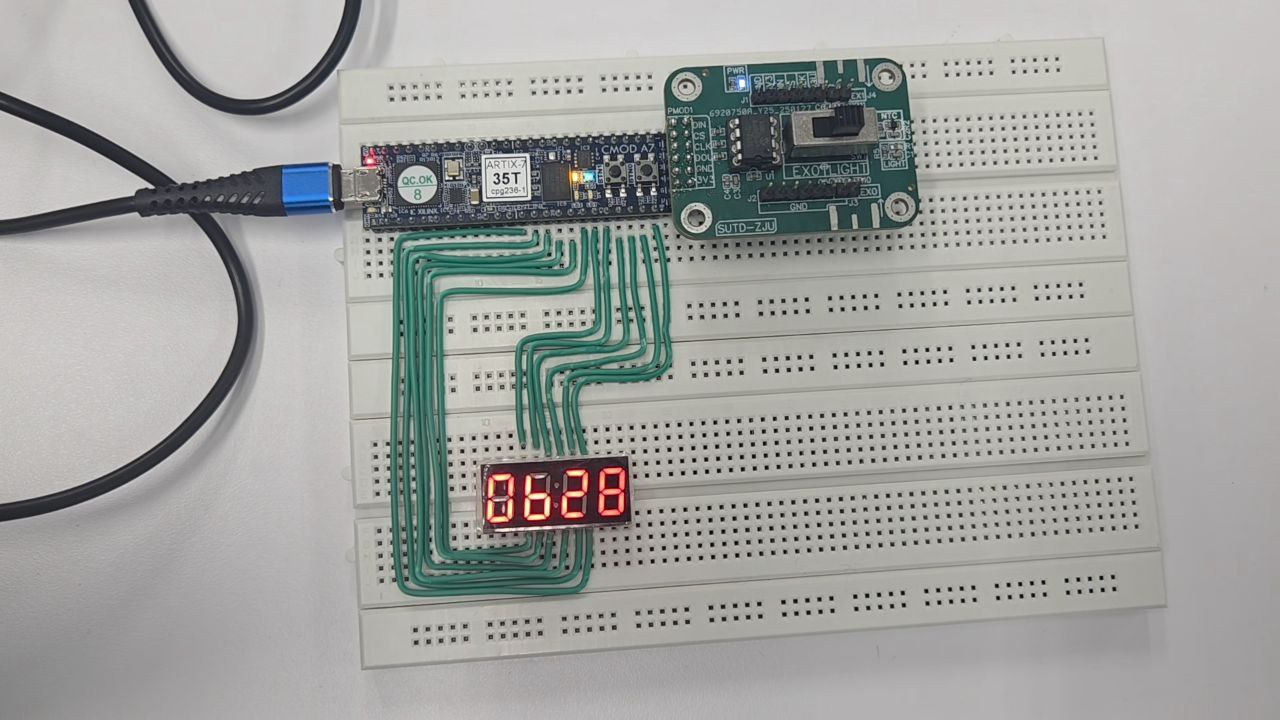

###Reset button pressed

#####7-segment display is blank when reset button is pressed

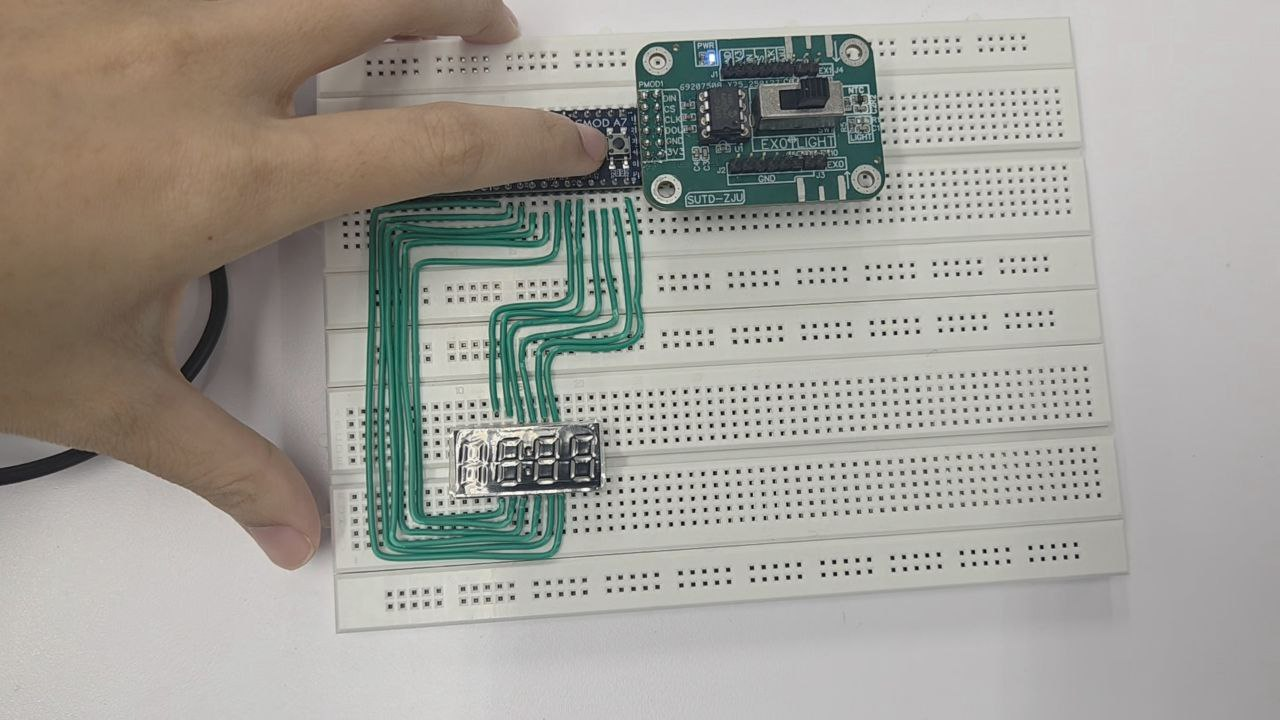

###Different amounts of light

#####Different HEX values shown when light sensor is covered and when light is shined on the sensor

Light sensor covered
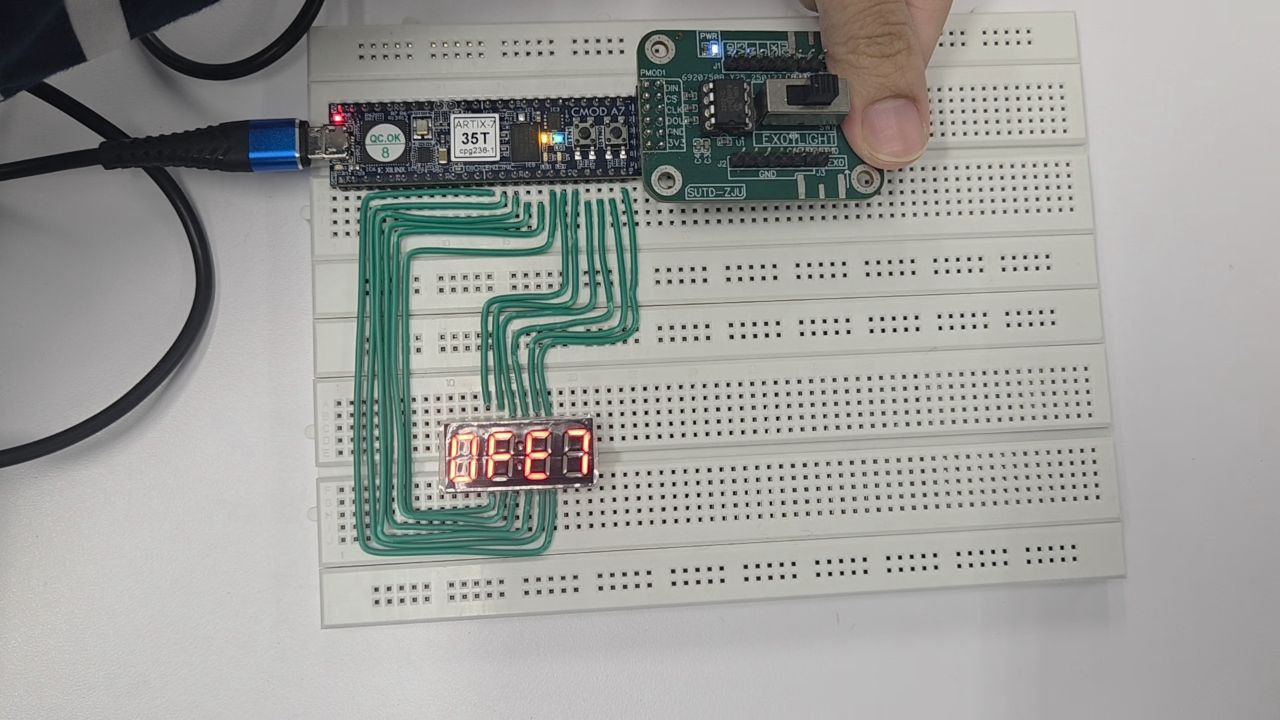

Light shine on light sensor
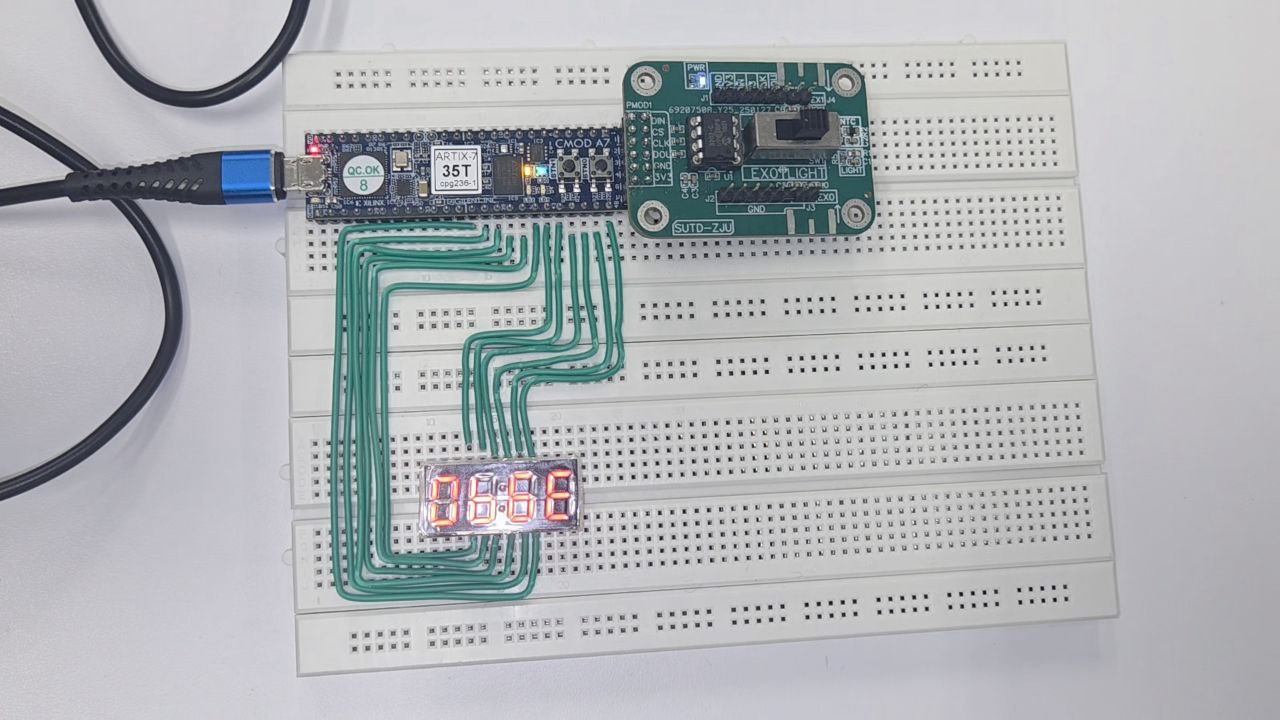

##Light sensor sampling -> UART Transmission to PC

###Transmission Display and 7-segment display

Transmission display corresponds with the HEX value displayed on the 7-segment display

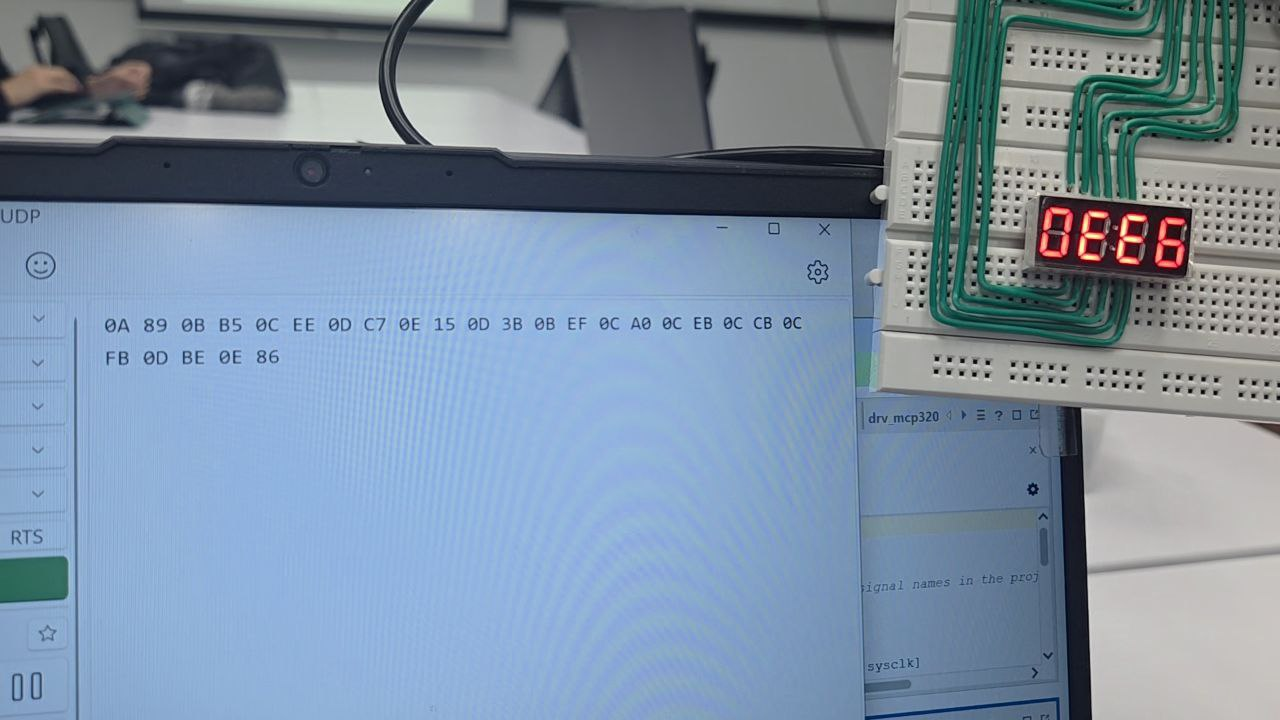

###Transmission display when reset button pressed

Transmission display is paused when reset button is pressed as no HEX value is displayed on 7-segment display

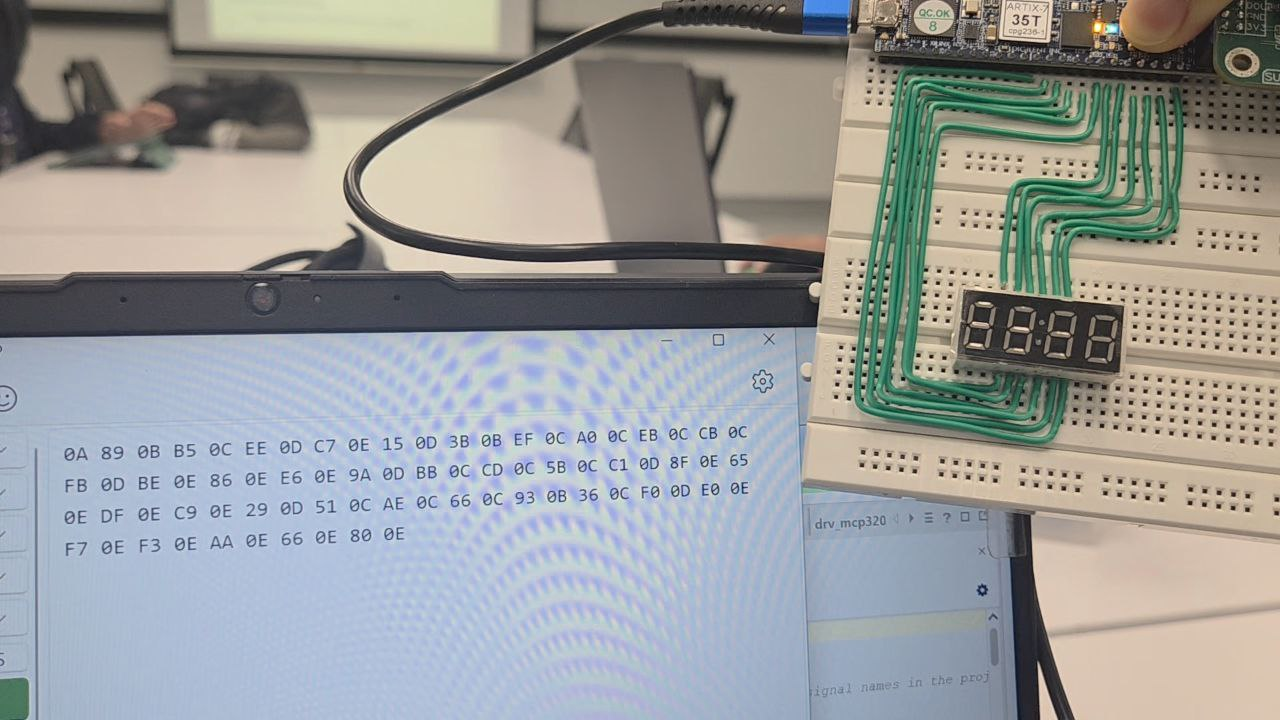